In [1]:
# Import


# Load the turbines' data and the mast data

In [1]:
DATA_ROOT = "data/data-EDPR/"
DATA_CLEAN_ROOT = 'data_clean'
DATA_PROD = "data_wind_prod.csv"
DATA_MAST = "wind-farm-1-metmast-2016.csv"
DATA_PROD_CLEAN = 'turbines_df.p'
DATA_MAST_CLEAN = 'mast.p'
DATA_FAILURES = 'wind-farm-1-failures-training.csv'

In [2]:
df = pd.read_pickle(os.path.join(DATA_CLEAN_ROOT, DATA_PROD_CLEAN))
mast = pd.read_pickle(os.path.join(DATA_CLEAN_ROOT, DATA_MAST_CLEAN))

NameError: name 'pd' is not defined

# Task 1: turbines' comparison

Here’s your first task: compare the energy produced by the four different turbines and find out whether there’s any turbine that is not giving the same results as the others.
Hint: comparing the turbines along the full year may not be enough: check their performances in different months.


### Question:
What kind of pattern do you see? Is there any hypothesis you can make? If you had to report to a business manager, what kind of insights would you bring?

There may not be a single right answer, what's important is that you back all your thoughts with what the data says!

# Task 2: demand side management

Your managers are asking you to check the impact of the four wind turbines at different times of the day, so that they can foresee the impact on demand management of investing in more turbines. For this task, you need to look at a typical day and check the energy produced by the four wind turbines at different times of the day.
Hint: look at differences across different months.


In [24]:
#we need to get all the data and group it by month first and then by hour
#we'll create a dummy df_ to get rid of the pandas multiindex
#once we're done with the grouping, we can delete df_ to save memory
df_ = df.reset_index(level=0).Grd_Prod_Pwr_Avg
energy_monthly_hourly_sum = df_.groupby(df_.index.month).apply(
    lambda x: (x/3).groupby(x.index.hour).sum())
del df_

In [25]:
energy_monthly_hourly_sum = energy_monthly_hourly_sum.unstack()
energy_monthly_hourly_sum.index.name = 'month'
energy_monthly_hourly_sum.columns.name = 'hour'

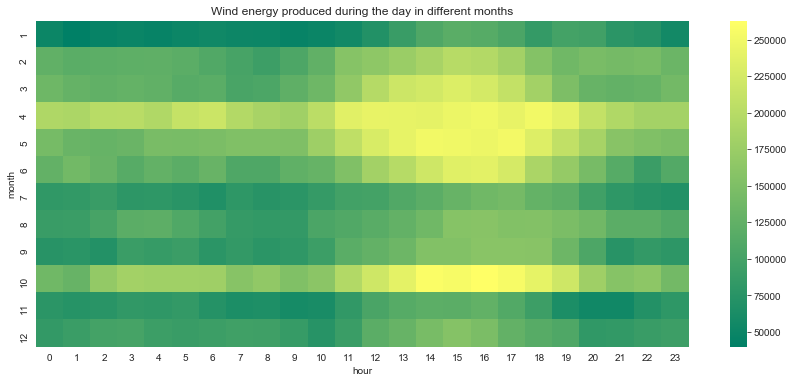

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(energy_monthly_hourly_sum, cmap='summer', square=True)
ax.set_title('Wind energy produced during the day in different months')
plt.show()

By this graph we can certainly say that there are some patterns: in Spring the wind is strong especially in the afternoon. The same is true for October. 

Now, let's do the same graph but separating the different turbines.

In [27]:
#same as before, we use a dummy df_ to do all our groupings.
#what we want to do is have the sum of the energy produced by hour, in each 
#month, for each turbine.
#this means that we first have to group by turbine ID, then take each turbine
#group and group again by month, and lastly, another groupby hour!

df_ = df.reset_index(level=0)
energy_monthly_hourly = df_.groupby(df_.Turbine_ID).Grd_Prod_Pwr_Avg.apply(
    lambda x: x.groupby(x.index.month).apply(
    lambda y: (y/3).groupby(y.index.hour).sum()))
del df_

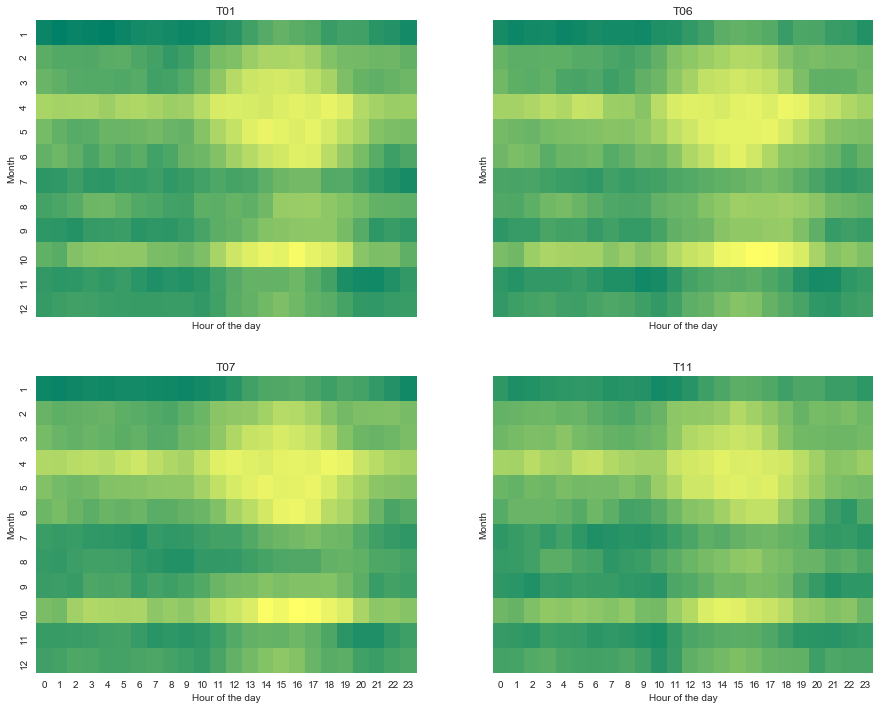

In [28]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2, 
                         sharex=True, sharey=True)

for i, turbine in enumerate(turbines):
    ax = axes.ravel()[i]
    turbine_energy_monthly_hourly = energy_monthly_hourly.loc[turbine].unstack()
    sns.heatmap(turbine_energy_monthly_hourly, cmap='summer', ax=ax, cbar=False, 
                vmin=energy_monthly_hourly.min(), vmax=energy_monthly_hourly.max())
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Month')
    ax.set_title(turbine)
plt.show()

It's really hard to spot patterns this way. We need to try a different representation. Notice that this is normal in the process of data science! You may lose a lot of time to try get some insight, just to find out that your approach was not ideal and you have to start all over with a different methodology.

Let's try ploting the sum of the energy produced by each turbine for each month as a lineplot.

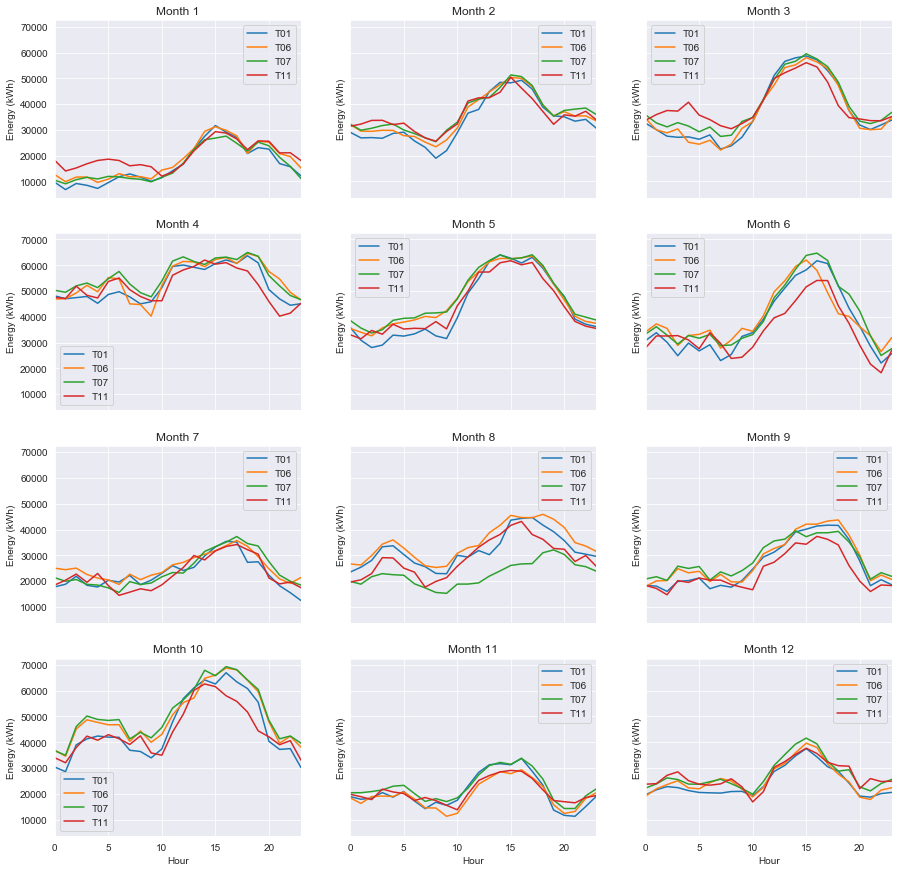

In [29]:
fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=3, 
                         sharex=True, sharey=True)

for i in range(12):
    ax = axes.ravel()[i]
    month = i+1
    for turbine in turbines:
        turbine_monthly_hourly_consumption = energy_monthly_hourly \
            .loc[turbine].loc[month]
        
        sns.lineplot(
            turbine_monthly_hourly_consumption.index, 
            turbine_monthly_hourly_consumption.values, 
            label=turbine, ax=ax)
        ax.set_xlim(0,23)
        ax.set_title(f'Month {month}')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Energy (kWh)')

Now we can definitely see some more patterns! Lineplots are much easier than the fancy heatmaps we tried before, yet are easier to read. Often, the simplest way is also the best.

### Questions: 

* What kind of pattern can you observe? 
* Do you see patterns that are specific of seasons, or turbine-specific patterns?
* What kind of recommendations would you give to your manager?

## Exercise 3 - Fault analysis

Now we're going to take a look at the different faults that occurred in the turbines. What we want to do is help our managers understand if there's any phenomenon visible in the data that we can use to predict a failure, or extract some insights on how we could potentially reduce them.

In [39]:
#load the failures dataset
failures = pd.read_csv(os.path.join(DATA_ROOT, DATA_FAILURES), delimiter=';')
failures.Timestamp = pd.to_datetime(failures.Timestamp)

## Look for the most common failures

In [40]:
failures.Turbine_ID.value_counts()

T06    7
T07    6
T09    5
T11    3
T01    2
Name: Turbine_ID, dtype: int64

In [41]:
failures = failures.loc[failures.Turbine_ID.isin(turbines)]

In [42]:
failures.Component.value_counts()

GENERATOR            7
HYDRAULIC_GROUP      5
TRANSFORMER          3
GENERATOR_BEARING    2
GEARBOX              1
Name: Component, dtype: int64

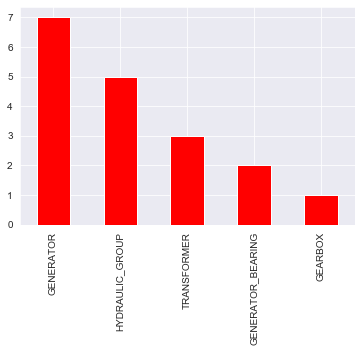

In [44]:
failures.Component.value_counts().plot(kind='bar', color='r')

Let's check if there's any turbine that particularly suffered from a certain failure.

In [45]:
failures_counts = failures.groupby('Turbine_ID').apply(
    lambda x: x.Component.value_counts())
failures_counts = failures_counts.unstack(fill_value=0)

In [46]:
failures_counts

,GEARBOX,GENERATOR,GENERATOR_BEARING,HYDRAULIC_GROUP,TRANSFORMER
Turbine_ID,,,,,
T01,1,0,0,0,1
T06,0,5,0,2,0
T07,0,1,2,1,2
T11,0,1,0,2,0


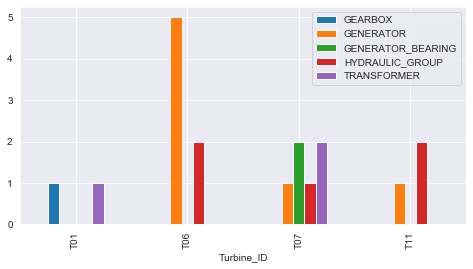

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
failures_counts.plot(kind='bar', ax=ax)

Looks like the generator of Turbine 06 has failed quite a lot! 5 times!

Let's check when the failures happened over time.

In [48]:
failures_timeline = failures.set_index('Timestamp').resample('M').Turbine_ID.apply(
    lambda x: x.value_counts())
failures_timeline = failures_timeline.unstack(fill_value=0)

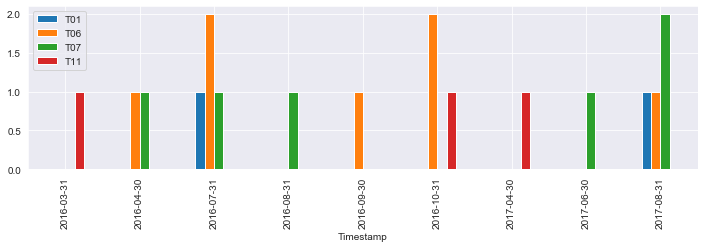

In [49]:
fig, ax = plt.subplots(figsize=(12,3))
failures_timeline.plot(kind='bar', ax=ax)
ax.set_xticklabels([i.get_text()[:10] for i in ax.get_xticklabels()])
plt.show()

Seems like the failures are quite distributed over time, and the generator of turbine 6 has been constatly failing every few months. Maybe there's something wrong with it? Some defect? Worth exploring more!


Also, we see that there are failures from 2016 and 2017, but we have turbine data just from 2017. Let's cut the failures dataset.

In [50]:
failures_2017 = failures.loc[failures.Timestamp.dt.year == 2017]

### Faults visualization
Let's see when the faults happened for different turbines

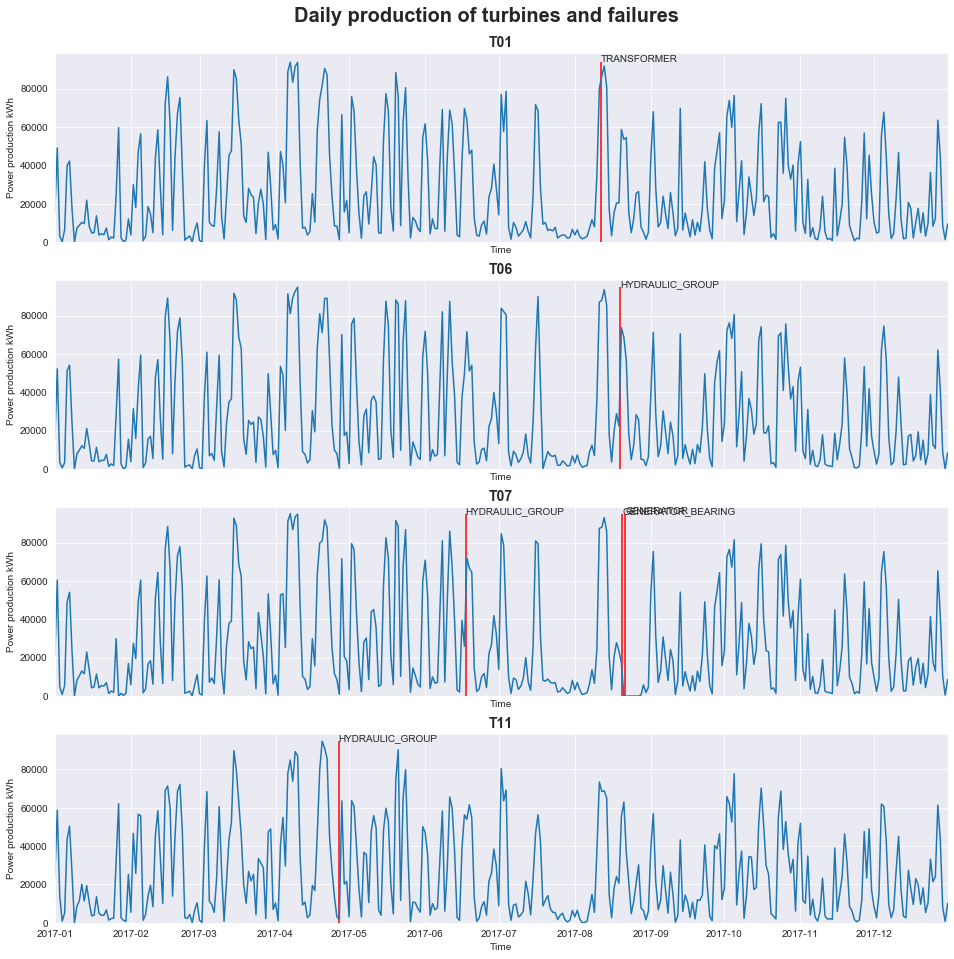

In [51]:
fig, axes = plt.subplots(figsize=(16,16), nrows=len(turbines), 
                         sharex=True, sharey=True)

for i, t in enumerate(turbines):
    energy_turbine = df.loc[t].Grd_Prod_Pwr_Avg.resample('D').sum() / 3
    failures_turbine = failures_2017.loc[failures_2017.Turbine_ID == t]
    ax = axes.ravel()[i]
    ax.plot(energy_turbine)
    ax.set_title(t, fontdict=dict(size=14, weight='bold'))
    
    ax.vlines(
        failures_turbine.Timestamp.values, 0, 
        energy_turbine.max(), color='red')
    for q, failure in failures_turbine.iterrows():
        ax.text(failure.Timestamp, energy_turbine.max(), failure.Component)
    
    ax.set_xlim(energy_turbine.index.min(), energy_turbine.index.max())
    ax.set_ylim(0)
    ax.set_ylabel("Power production kWh")
    ax.set_xlabel("Time")

plt.suptitle('Daily production of turbines and failures', 
             fontsize=20, fontweight='bold', y=.92)
plt.show()

### Inspecting failures
Let's check what happened to key parameters right before a failure occurred.

In [52]:
failures_march = failures.loc[failures.Timestamp.dt.month==3]

In [53]:
#to do this part, we'll create a helper function so that we can more easily
#inspect what happened during a certain function

def inspect_failure(failures_subset, variable):
    fig, ax = plt.subplots(figsize=(16,4))
    
    #we'll plot what happened from a month before to 3 days after a failure
    min_date = failures_subset.Timestamp.min() - pd.DateOffset(months=1)
    max_date = failures_subset.Timestamp.max() + pd.DateOffset(days=3)
    
    for t in turbines:
        data = df.loc[t].loc[min_date : max_date][variable]
        data.plot(ax = ax, label=t, alpha=.6)
    
    for i, failure in failures_subset.iterrows():
        height_failure = data.loc[failure.Timestamp.date()].mean()
        ax.vlines(failure.Timestamp, 0, height_failure)
        ax.text(failure.Timestamp, height_failure * 1.05, 
                f'{failure.Component} {failure.Turbine_ID}')
        print(f'{failure.Timestamp} - {failure.Turbine_ID} \
        - {failure.Component} - {failure.Remarks}')
    
    ax.legend()
    ax.set_ylim(0,)
    ax.set_xlim(min_date, max_date)
    plt.show()

Let's plot the failure that T11 had in April

In [54]:
failure_t11_april = failures_2017.loc[failures_2017.Timestamp.dt.month==4]

In [55]:
failure_t11_april

,Turbine_ID,Component,Timestamp,Remarks
17,T11,HYDRAULIC_GROUP,2017-04-26 18:06:00+00:00,Hydraulic group error in the brake circuit


2017-04-26 18:06:00+00:00 - T11         - HYDRAULIC_GROUP - Hydraulic group error in the brake circuit


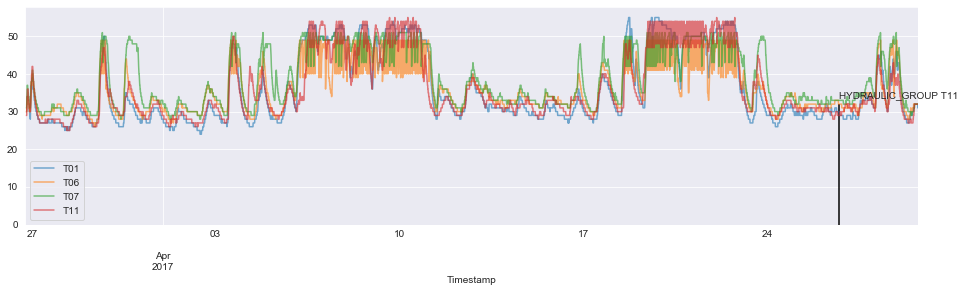

In [56]:
inspect_failure(failure_t11_april, 'Hyd_Oil_Temp_Avg')

If you look at the temperature of the oil for T11 you can see that it was higher than the other turbines for consistent periods before the failure occurred. There seem to be some strong signal for incoming failure in this variable!

Let's now look at another failure. How about the one that T7 had in June?

In [41]:
failure_t7_june = failures_2017.loc[failures_2017.Timestamp.dt.month==6]

In [42]:
failure_t7_june

,Turbine_ID,Component,Timestamp,Remarks
18,T07,HYDRAULIC_GROUP,2017-06-17 11:35:00,Oil leakage in Hub


2017-06-17 11:35:00 - T07         - HYDRAULIC_GROUP - Oil leakage in Hub


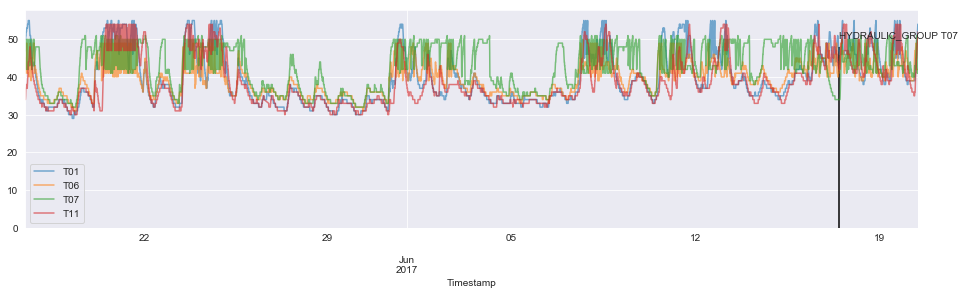

In [43]:
inspect_failure(failure_t7_june, 'Hyd_Oil_Temp_Avg')

Also here the temperature of the oil in the hydraulic group of T07 seems to be almost always higher than the same varialble in other turbines. A confirmation that there's strong predictive power in that variable.

Now, let's check all the failures that happened in August (there are many)

In [44]:
failures_august = failures_2017.loc[failures_2017.Timestamp.dt.month==8]

In [45]:
failures_august

,Turbine_ID,Component,Timestamp,Remarks
19,T01,TRANSFORMER,2017-08-11 13:14:00,Transformer fan damaged
20,T06,HYDRAULIC_GROUP,2017-08-19 09:47:00,Oil leakage in Hub
21,T07,GENERATOR_BEARING,2017-08-20 06:08:00,Generator bearings damaged
22,T07,GENERATOR,2017-08-21 14:47:00,Generator damaged


2017-08-11 13:14:00 - T01         - TRANSFORMER - Transformer fan damaged
2017-08-19 09:47:00 - T06         - HYDRAULIC_GROUP - Oil leakage in Hub
2017-08-20 06:08:00 - T07         - GENERATOR_BEARING - Generator bearings damaged
2017-08-21 14:47:00 - T07         - GENERATOR - Generator damaged


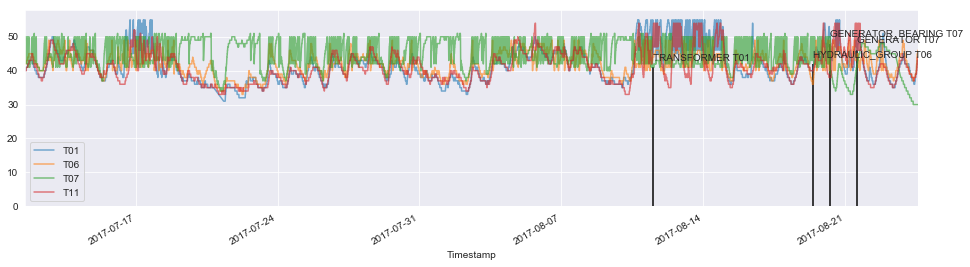

In [46]:
inspect_failure(failures_august, 'Hyd_Oil_Temp_Avg')

It's hard to spot patterns here as 3 turbines failed in a short period of time! Anyway, we can already see something that can be confusing: the turbine T06 (in orange) had a failure in its hydraulic group but there seem to be no sign of it in the temperature of the oil. On the other hand, the same variable seem to be constantly higher than it should for T07, that experienced a failure in its generator.

Probably, we can say that the temperature of the oil is not enough to forecast a failure: we need to look at the joint effects of different variables. 

The best way to do is is a scatterplot.

In [47]:
#again, we'll create a helper function that will be useful to speed up testing
def plot_failure_scatter(failures_subset, variables):
    fig, ax = plt.subplots(figsize=(8,8))
    
    min_date = failures_subset.Timestamp.min() - pd.DateOffset(months=1)
    max_date = failures_subset.Timestamp.max() + pd.DateOffset(days=3)
    
    for t in turbines:
        turbine_data = df.loc[t].loc[min_date : max_date]\
        .resample('6h').mean()[variables]
        sns.scatterplot(data=turbine_data, x=variables[0], y=variables[1], 
                        alpha=.5, label=t, ax=ax)

    for i, failure in failures_subset.iterrows():
        fault_data = df.loc[t].loc[failure.Timestamp.date()]
        ax.scatter(data=fault_data, x=variables[0], y=variables[1], 
                   marker='x', s=200, color='r')
        ax.text(fault_data[variables[0]], fault_data[variables[1]] * 1.1, 
                f'{failure[["Component", "Turbine_ID"]]}')
        print(f'{failure.Timestamp} - {failure.Turbine_ID} - \
        {failure.Component} - {failure.Remarks}')

    plt.show()

Let's look into the temperature of the oil and the production of T11 when it failed in April

2017-04-26 18:06:00 - T11 -         HYDRAULIC_GROUP - Hydraulic group error in the brake circuit


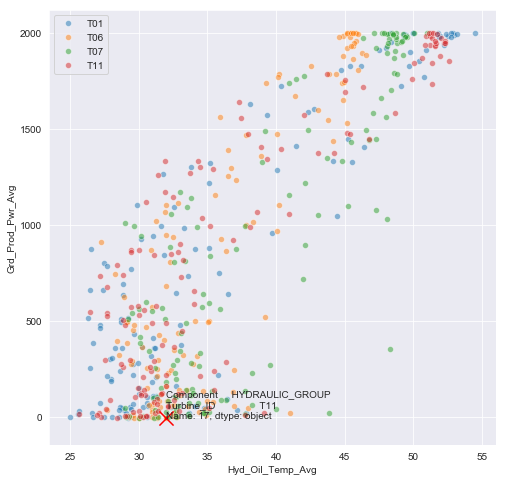

In [48]:
plot_failure_scatter(failure_t11_april, ['Hyd_Oil_Temp_Avg', 'Grd_Prod_Pwr_Avg'])

As expected, there's no power production during failure (the turbine is off), but we can't see anything happening on the oil temperature.

Let's plot the failure of T7 in June

2017-06-17 11:35:00 - T07 -         HYDRAULIC_GROUP - Oil leakage in Hub


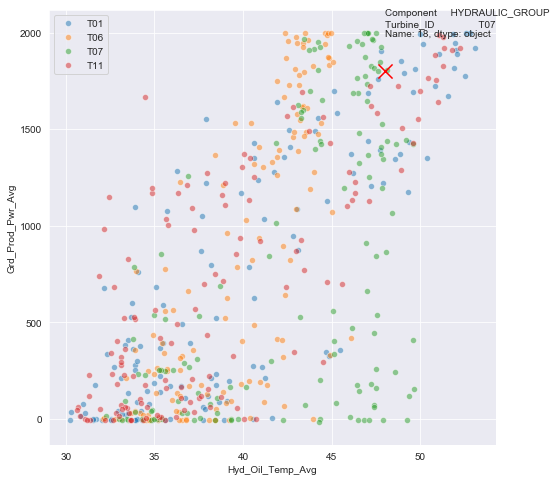

In [49]:
plot_failure_scatter(failure_t7_june, ['Hyd_Oil_Temp_Avg', 'Grd_Prod_Pwr_Avg'])

Looks like the oil was at a very high temperature, but nothing too extreme considering the energy production at that time.

Let's see now the failures of august, looking at the temperature of the generator bearing and the production.

2017-08-11 13:14:00 - T01 -         TRANSFORMER - Transformer fan damaged
2017-08-19 09:47:00 - T06 -         HYDRAULIC_GROUP - Oil leakage in Hub
2017-08-20 06:08:00 - T07 -         GENERATOR_BEARING - Generator bearings damaged
2017-08-21 14:47:00 - T07 -         GENERATOR - Generator damaged


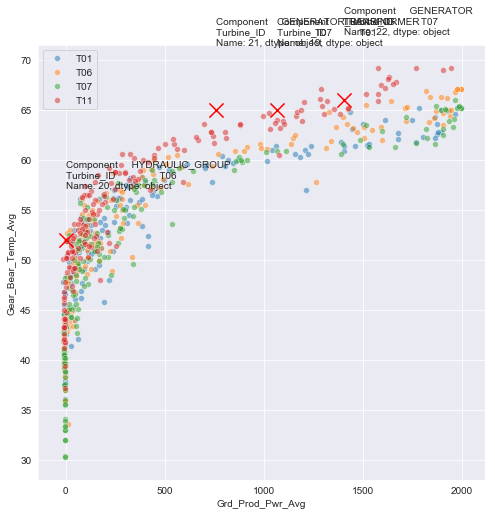

In [50]:
plot_failure_scatter(failures_august, ['Grd_Prod_Pwr_Avg', 'Gear_Bear_Temp_Avg', ])

Interesting! looks like the failures occured when the temperature of the bearing was higher than usual for a specific production of energy! We finally found a cue, something that we can look at to try predicting failures. Notice that this took some time, it's normal that before finding something useful you may have to go through some trial and error with your analysis.

Now, let's look at both the temperature of the oil of the gearbox and the bearing.

2017-08-11 13:14:00 - T01 -         TRANSFORMER - Transformer fan damaged
2017-08-19 09:47:00 - T06 -         HYDRAULIC_GROUP - Oil leakage in Hub
2017-08-20 06:08:00 - T07 -         GENERATOR_BEARING - Generator bearings damaged
2017-08-21 14:47:00 - T07 -         GENERATOR - Generator damaged


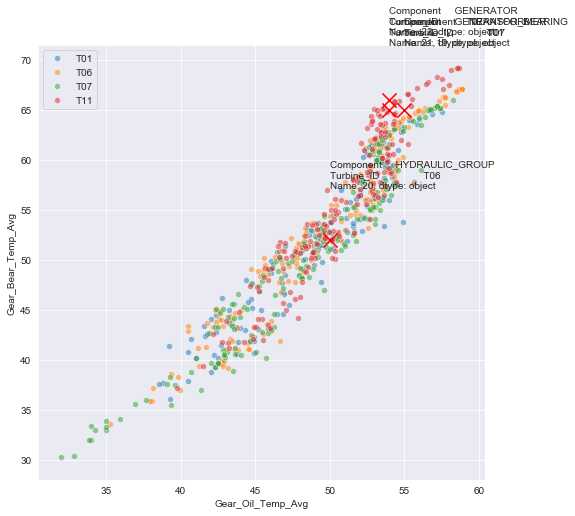

In [51]:
plot_failure_scatter(failures_august, ['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', ])

Also here it seems that most failure happen at very high temperatures. That makes sense.

Lastly, let's look into the relationhip between energy production and speed of the generator.

2017-08-11 13:14:00 - T01 -         TRANSFORMER - Transformer fan damaged
2017-08-19 09:47:00 - T06 -         HYDRAULIC_GROUP - Oil leakage in Hub
2017-08-20 06:08:00 - T07 -         GENERATOR_BEARING - Generator bearings damaged
2017-08-21 14:47:00 - T07 -         GENERATOR - Generator damaged


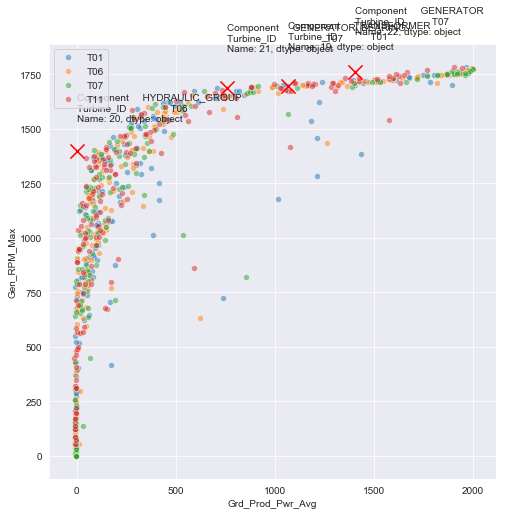

In [52]:
plot_failure_scatter(failures_august, ['Grd_Prod_Pwr_Avg', 'Gen_RPM_Max'])

Also here it seems that most failures happen when the generator is going faster than it should for a specific energy production.

We finally started observing some useful patterns, that we can tell our business managers so that we can fund some deeper research into how to prevent failures.

### Questions:
* Do you think it was possible to make hypothesis on turbines' failures from looking at their data?
* Can you spot patterns for every kind of failure?
* How far in advance can you spot failure patterns in this data?